<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия." data-toc-modified-id="Линейная-регрессия.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия.</a></span></li><li><span><a href="#Дерево-решений." data-toc-modified-id="Дерево-решений.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений.</a></span></li><li><span><a href="#Случайный-лес." data-toc-modified-id="Случайный-лес.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес.</a></span></li><li><span><a href="#CatBoost." data-toc-modified-id="CatBoost.-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost.</a></span></li><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод.</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [3]:
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df_taxi.index.is_monotonic

True

In [6]:
df_taxi = df_taxi.resample('1H').sum()
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод.

- Данные в предварительной обработке не нуждаются;
- Для данных провели ресемплирование по одному часу.

## Анализ

In [7]:
df_taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
def decompose_graph(data):
    plt.figure(figsize=(20, 25))

    plt.subplot(311)
    data.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    data.seasonal.plot(ax=plt.gca())
    plt.title('Seasonal')

    plt.subplot(313)
    data.resid.plot(ax=plt.gca())
    plt.title('Residual')
    
    plt.show()

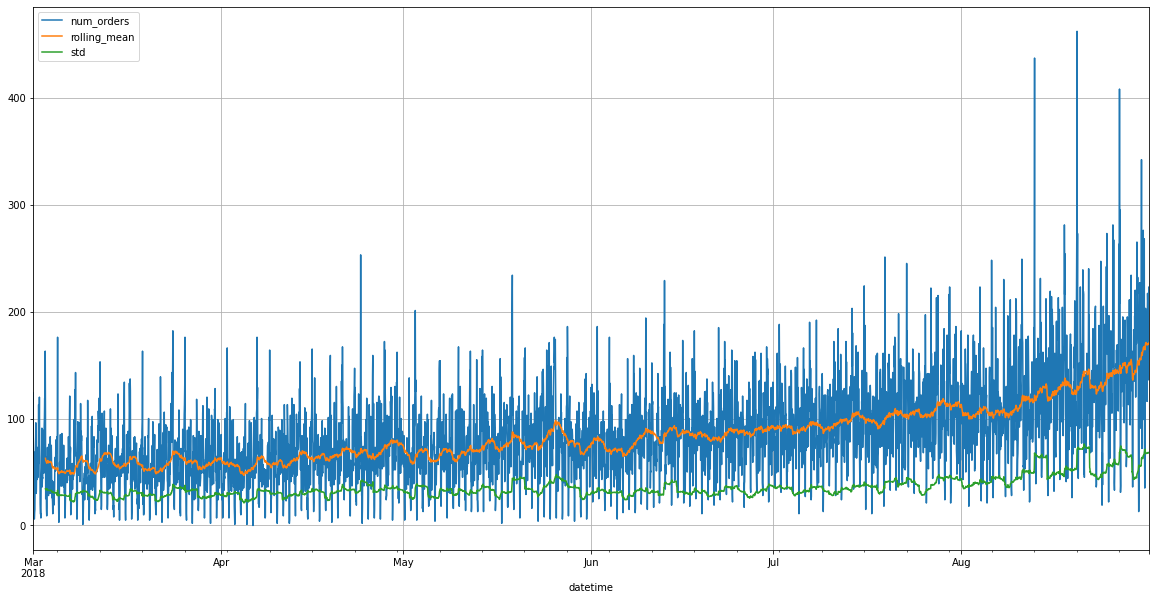

In [9]:
df_plot = df_taxi.copy()

window_size = 50

df_plot['rolling_mean'] = df_taxi.rolling(window_size).mean()
df_plot['std'] = df_taxi.rolling(window_size).std()

df_plot.plot(figsize=(20, 10), grid=True);

- Стандартное отклонение и скользящее среднее увеличиваются со временем. Следовательно, ряд нестационарный.
- От месяца к месяцу наблюдается тренд на увеличение количества заказов.

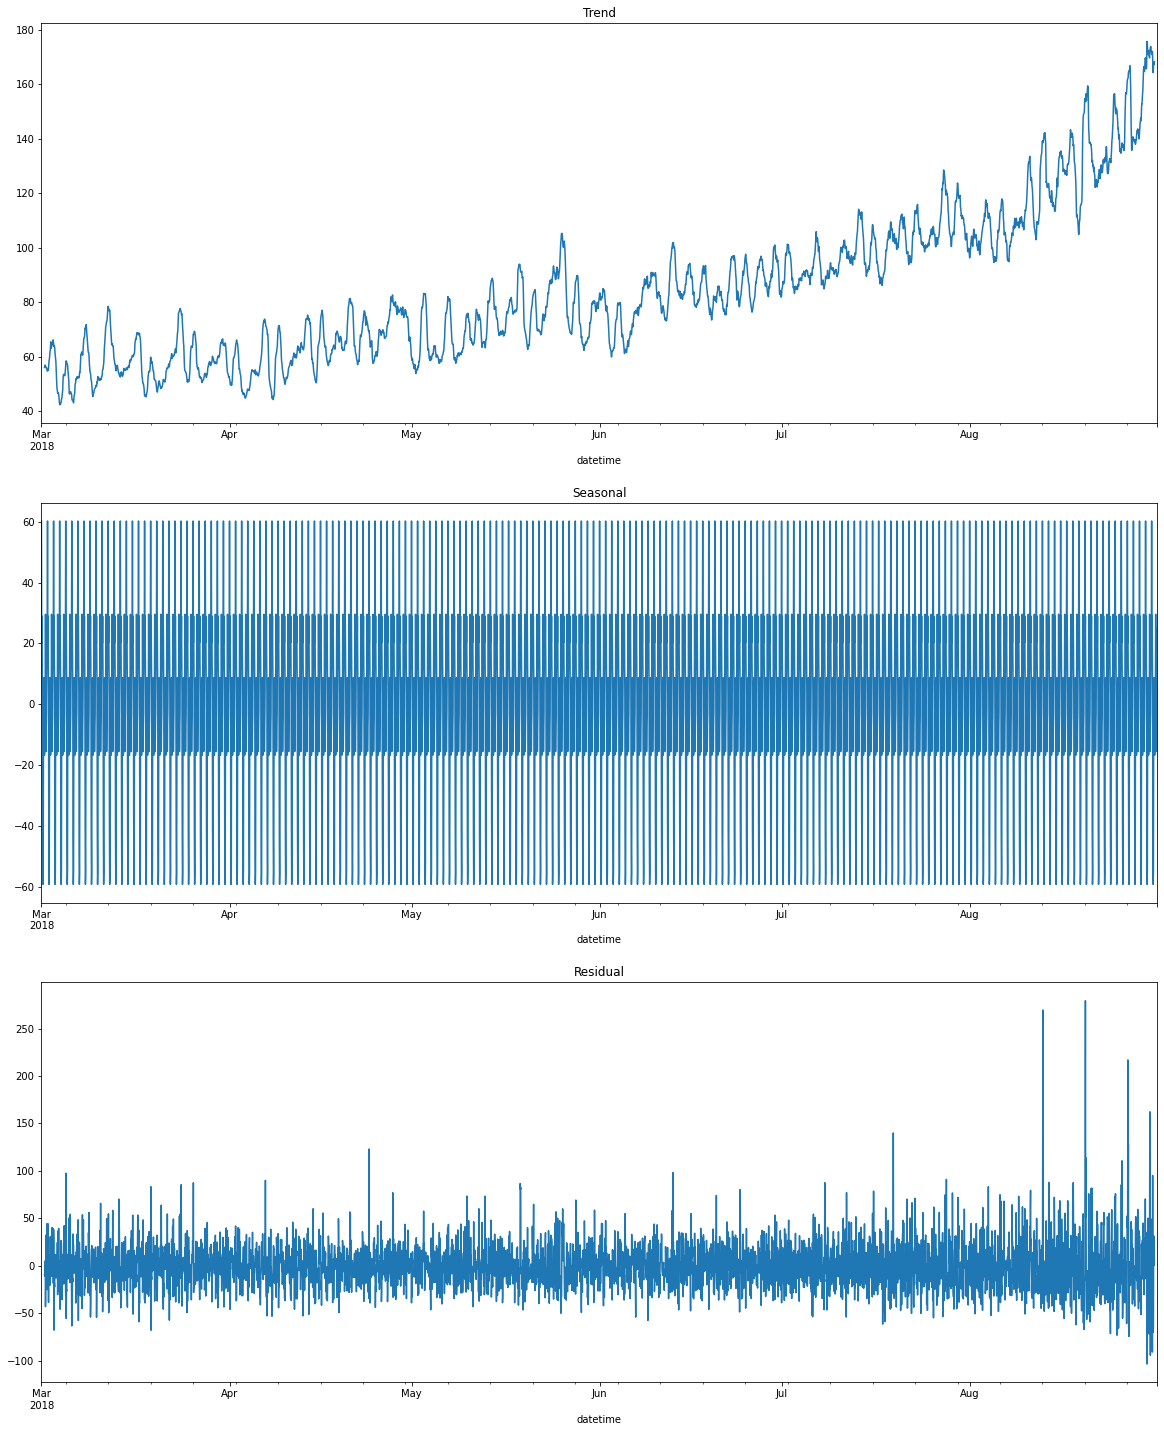

In [10]:
decomposed = seasonal_decompose(df_taxi)
decompose_graph(decomposed)

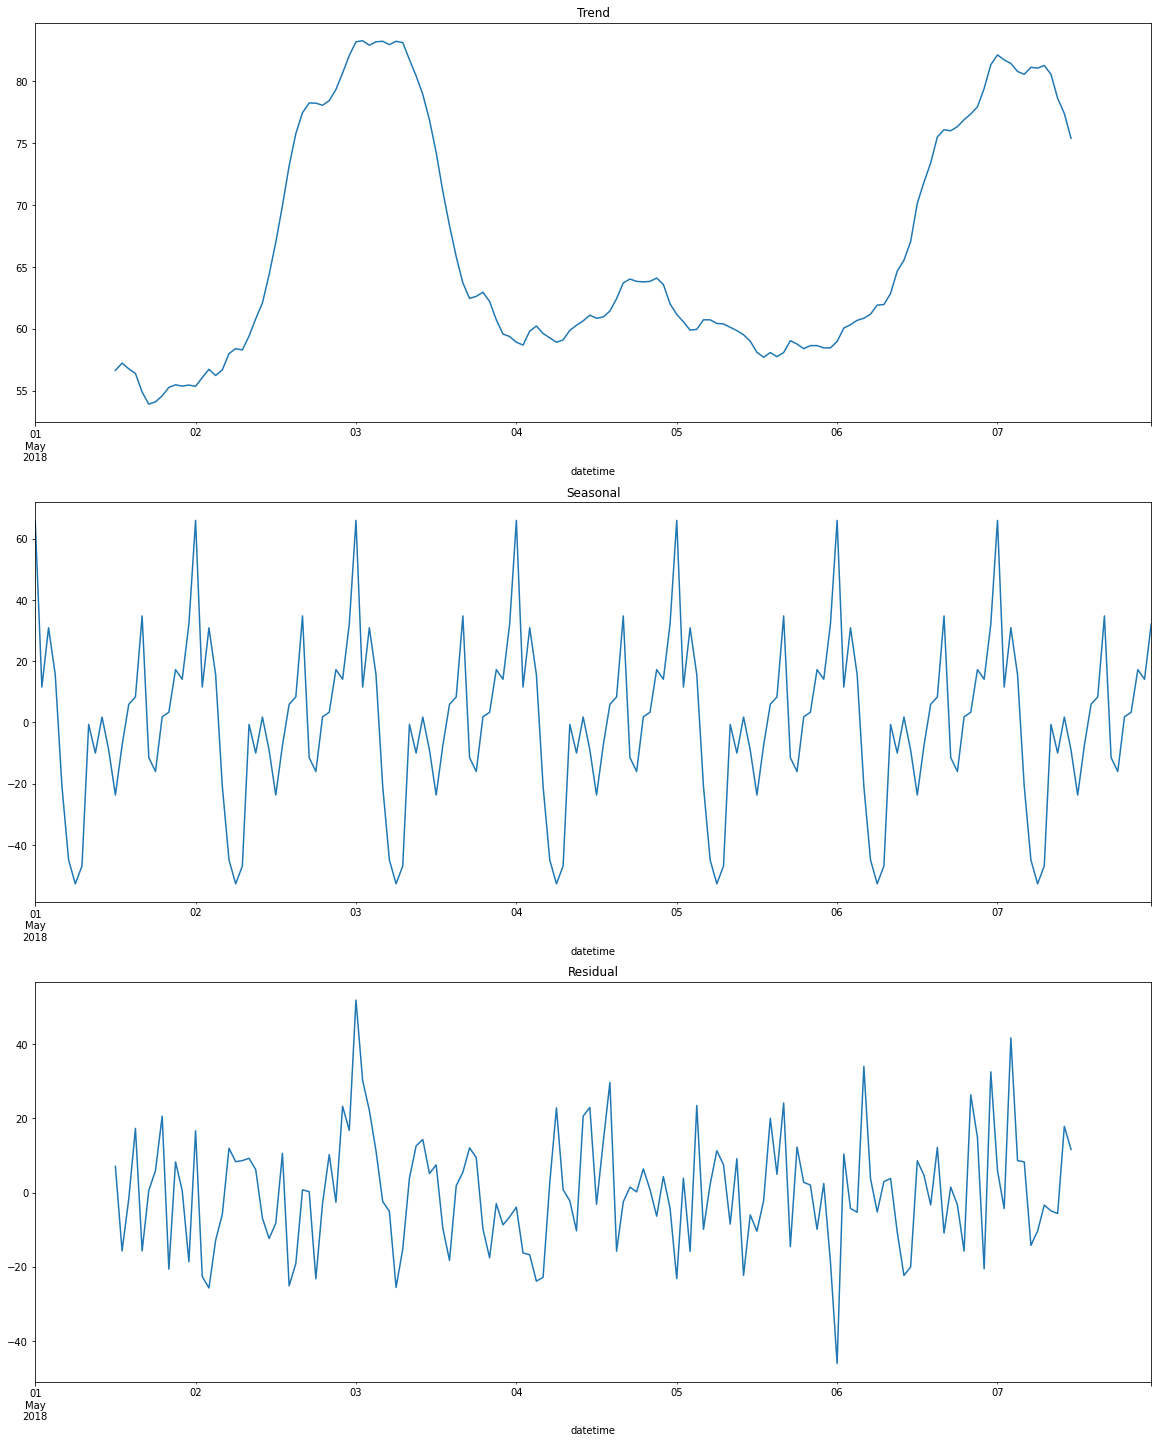

In [11]:
decomposed = seasonal_decompose(df_taxi['2018-05-01':'2018-05-07'])
decompose_graph(decomposed)

По графикам видно, что присутствует сезонность и восходящий тренд.

Рассмотрим подробнее график сезонности, чтобы понять, в какие часы наоблюдается пиковая нагрузка.

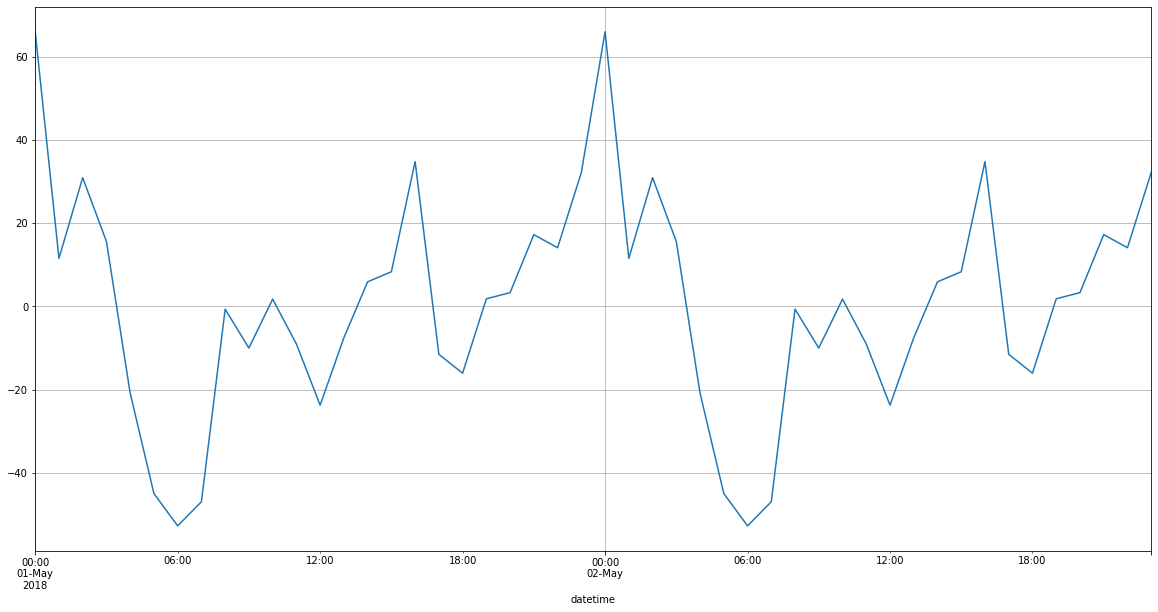

In [12]:
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(figsize=(20, 10), grid=True);

### Вывод.

На основании анализа временного ряда можно сделать следующие выводы:
- Ряд не является стационарным, так как его скользящее среднее и стандартное отклонение увеличиваются со временем;
- Наблюдается тренд на увеличение количества заказов от месяца к месяцу;
- В данных присутствует сезонность;
- Наибольшее число заказов приходится на время 16:00-17:00 часов и 00:00 часов, наименьшее - на 6:00 утра.

## Обучение

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data.dropna(inplace=True)

In [14]:
def rmse(target, predict):
    return mean_squared_error(target, predict) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [15]:
def best_hyperparams(estimator, grid_space):
    tscv = TimeSeriesSplit(n_splits=8)
    
    grid = GridSearchCV(estimator=estimator,
                        param_grid=grid_space,
                        cv=tscv,
                        scoring=rmse_scorer,
                        verbose=100)

    grid.fit(features_train, target_train)
    
    return grid

In [16]:
comp_table = {}
index = ['rmse']

In [17]:
make_features(df_taxi, 24, 48)

In [18]:
df_taxi.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,5,0,72.0,119.0,101.0,93.0,49.0,89.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,108,3,5,1,163.0,72.0,119.0,101.0,93.0,49.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,25,3,5,2,108.0,163.0,72.0,119.0,101.0,93.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,64,3,5,3,25.0,108.0,163.0,72.0,119.0,101.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,44,3,5,4,64.0,25.0,108.0,163.0,72.0,119.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333


In [19]:
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)

In [20]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

print('train:', features_train.shape, target_train.shape)
print('test:', features_test.shape, target_test.shape)

train: (3931, 28) (3931,)
test: (437, 28) (437,)


### Линейная регрессия.

In [21]:
%%time

score = cross_val_score(LinearRegression(), features_train, target_train,
                        cv=TimeSeriesSplit(n_splits=8),
                        scoring='neg_root_mean_squared_error').mean()

CPU times: user 526 ms, sys: 1.11 s, total: 1.63 s
Wall time: 1.65 s


In [22]:
comp_table['linear'] = abs(score)

print('best rmse:', abs(score))

best rmse: 26.81576753134211


### Дерево решений.

In [23]:
grid_space = {'max_depth': range(1, 20),}

In [24]:
%%time

grid = best_hyperparams(DecisionTreeRegressor(random_state=12345), grid_space)

Fitting 8 folds for each of 19 candidates, totalling 152 fits
[CV 1/8; 1/19] START max_depth=1................................................
[CV 1/8; 1/19] END ..............................max_depth=1; total time=   0.0s
[CV 2/8; 1/19] START max_depth=1................................................
[CV 2/8; 1/19] END ..............................max_depth=1; total time=   0.0s
[CV 3/8; 1/19] START max_depth=1................................................
[CV 3/8; 1/19] END ..............................max_depth=1; total time=   0.0s
[CV 4/8; 1/19] START max_depth=1................................................
[CV 4/8; 1/19] END ..............................max_depth=1; total time=   0.0s
[CV 5/8; 1/19] START max_depth=1................................................
[CV 5/8; 1/19] END ..............................max_depth=1; total time=   0.0s
[CV 6/8; 1/19] START max_depth=1................................................
[CV 6/8; 1/19] END ............................

In [25]:
comp_table['tree'] = abs(grid.best_score_)

print('best params:', grid.best_params_)
print('best rmse:', abs(grid.best_score_))

best params: {'max_depth': 5}
best rmse: 29.577548541632645


### Случайный лес.

In [26]:
grid_space = {'max_depth': range(1, 20),
             'n_estimators': range(10, 110, 10),}

In [27]:
%%time

grid = best_hyperparams(RandomForestRegressor(random_state=12345), grid_space)

Fitting 8 folds for each of 190 candidates, totalling 1520 fits
[CV 1/8; 1/190] START max_depth=1, n_estimators=10..............................
[CV 1/8; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 2/8; 1/190] START max_depth=1, n_estimators=10..............................
[CV 2/8; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 3/8; 1/190] START max_depth=1, n_estimators=10..............................
[CV 3/8; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 4/8; 1/190] START max_depth=1, n_estimators=10..............................
[CV 4/8; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 5/8; 1/190] START max_depth=1, n_estimators=10..............................
[CV 5/8; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 6/8; 1/190] START max_depth=1, n_estimators=10..............................
[CV 6/8; 1/190] END ............max_depth=1, 

In [28]:
comp_table['forest'] = abs(grid.best_score_)

print('best params:', grid.best_params_)
print('best rmse:', abs(grid.best_score_))

best params: {'max_depth': 19, 'n_estimators': 100}
best rmse: 24.469544361194348


### CatBoost.

In [29]:
grid_space = {'n_estimators': range(100, 1100, 100),
              'max_depth': range(1, 11),}

In [30]:
%%time

grid = best_hyperparams(CatBoostRegressor(random_state=12345, learning_rate=0.5, verbose=100), grid_space)

Fitting 8 folds for each of 100 candidates, totalling 800 fits
[CV 1/8; 1/100] START max_depth=1, n_estimators=100.............................
0:	learn: 26.4363416	total: 50.9ms	remaining: 5.04s
99:	learn: 13.6700166	total: 72.5ms	remaining: 0us
[CV 1/8; 1/100] END ...........max_depth=1, n_estimators=100; total time=   1.1s
[CV 2/8; 1/100] START max_depth=1, n_estimators=100.............................
0:	learn: 26.0517539	total: 470us	remaining: 46.5ms
99:	learn: 16.2304571	total: 30.5ms	remaining: 0us
[CV 2/8; 1/100] END ...........max_depth=1, n_estimators=100; total time=   0.6s
[CV 3/8; 1/100] START max_depth=1, n_estimators=100.............................
0:	learn: 27.1477889	total: 521us	remaining: 51.6ms
99:	learn: 17.8064181	total: 35.5ms	remaining: 0us
[CV 3/8; 1/100] END ...........max_depth=1, n_estimators=100; total time=   0.7s
[CV 4/8; 1/100] START max_depth=1, n_estimators=100.............................
0:	learn: 28.0271905	total: 560us	remaining: 55.5ms
99:	learn

In [31]:
comp_table['catboost'] = abs(grid.best_score_)

print('best params:', grid.best_params_)
print('best rmse:', abs(grid.best_score_))

best params: {'max_depth': 3, 'n_estimators': 100}
best rmse: 25.38749124058732


In [32]:
pd.DataFrame(comp_table, index=index)

,linear,tree,forest,catboost
rmse,26.815768,29.577549,24.469544,25.387491


### Вывод.

Были рассмотрены следующие модели машинного обучения: `LinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`, `CatBoostRegressor`. Для каждой модели, кроме линейной регрессии, были подобраны оптимальные гиперпараметры:
- `DecisionTreeRegressor`: max_depth = 5;
- `RandomForestRegressor`: max_depth = 19, n_estimators = 100;
- `CatBoostRegressor`: max_depth = 3, n_estimators = 100.

Для дальнейшего тестирования возьмем модель, которая показала наилучшие значентя метрики `rmse` - `RandomForestRegressor`.

## Тестирование

In [33]:
model = RandomForestRegressor(max_depth=19, n_estimators=100)
model.fit(features_train, target_train)

predictions = model.predict(features_test)

print('rmse на тестовых данных:', rmse(target_test, predictions))

rmse на тестовых данных: 44.25349478373386


In [34]:
predictions = pd.DataFrame(predictions, index=target_test.index)
predictions.head()

,0
datetime,
2018-08-13 19:00:00,103.151159
2018-08-13 20:00:00,100.534747
2018-08-13 21:00:00,114.376703
2018-08-13 22:00:00,128.613000
2018-08-13 23:00:00,130.402500


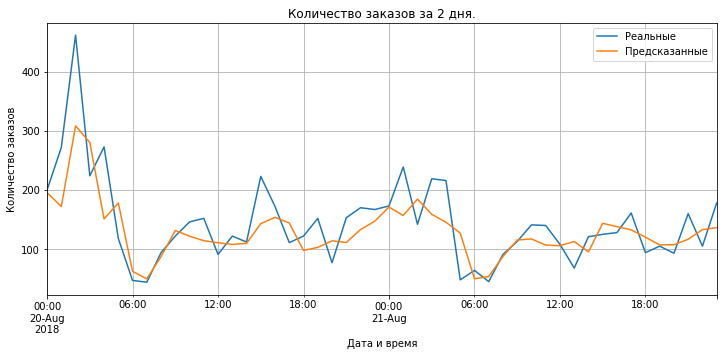

In [35]:
target_test['2018-08-20':'2018-08-21'].plot(ax=plt.gca(), figsize=(12, 5))
predictions['2018-08-20':'2018-08-21'].plot(ax=plt.gca(), figsize=(12, 5))

plt.legend(['Реальные', 'Предсказанные'])
plt.title('Количество заказов за 2 дня.')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid(which='both')
plt.show()

## Вывод.

От нас требовалось построить модель машинного обучения для прогнозирования количества заказов такси на следующий час. Для этого была проделана следующая работа:
- Проведена предварительная обработка данных, в результате которой данные были ресемплированы по одному часу;
- Проведен анализ полученных данных, результаты которого следующие:
    - Временной ряд не является стационарным;
    - В ряду присутствует сезонность и тренд на увеличение количества заказов каждый последующий месяц;
    - Наибольшее число заказов наблюдается в промежуток времени 16:00-17:00 и в 00:00 часов. Наименьшее - в 6:00 часов.
- Для обучения были выбраны 4 модели и для них подобраны оптимальные гиперпараметры:
    - `LinearRegression`: без подбора гиперпараметров;
    - `DecisionTreeRegressor`: max_depth = 5;
    - `RandomForestRegressor`: max_depth = 19, n_estimators = 100;
    - `CatBoostRegressor`: max_depth = 3, n_estimators = 100
- В ходе финального тестирования модель `RandomForestRegressor` с подобранными гиперпараметрами показала метрику `rmse`, равную 43.87, что соответствует требования задачи.